## First Notebook 


1. Importing financial trading data from Kite Connect API

2. Understand how mlfinlab package is used. Understand how dollar,volume and Information bars are created

3. Characteristics of different bar sampled data

4. Identify Data cleaning strategies

5. Clean Data 

6. Visualize Data



## Importing Libs

In [91]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [92]:
## path of mlfin lab-- Siddharth to change this variable only 
mlfinpath = 'C:/Study/HedgeFund/mlfinlab'
ourpath = "C:/Study/HedgeFund/MLFinance/src"

In [305]:
import sys
sys.path.append(mlfinpath)
sys.path.append(ourpath)
import numpy as np
from pathlib import Path
import pandas as pd
import datetime 
import logging
from kiteconnect import KiteConnect
from collections import defaultdict
import re
from kite_downloader import *
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from mlfinlab.datasets import *
from mlfinlab.data_structures import *

In [267]:
savepath = 'C:/Study/HedgeFund/datasets/'

In [4]:
Path.ls = lambda x: list(x.iterdir())

## Reading different data  samples
From Mlfinlab

In [ ]:
tick_df =  load_tick_sample()
stocks_df = load_stock_prices()
dol_df = load_dollar_bar_sample()

In [ ]:
tick_df.shape,stocks_df.shape,dol_df.shape

In [ ]:
tick_df.head(10)

In [ ]:
tick_res_df=tick_df.reset_index()

When working with our own data, we need to either those datasets within data folder of mlfinlan datasets or create a new library using their code as starter code

## Reading Bitcoin Datasets

In [178]:
datapath = Path('C:/Study/HedgeFund/datasets/')

In [179]:
datapath.ls()

[WindowsPath('C:/Study/HedgeFund/datasets/bitstampUSD.csv'),
 WindowsPath('C:/Study/HedgeFund/datasets/coinbaseUSD.csv'),
 WindowsPath('C:/Study/HedgeFund/datasets/nifty_fno.csv')]

In [180]:
dfs = []
for dpath in bitcoinpath.ls():
    dfs.append(pd.read_csv(dpath))

In [181]:
## printing the data stats 
for df,name in zip(dfs,bitcoinpath.ls()):
    print(f"Data:{name.name.split('.')[0]}")
    print(f"Shape of Dataset:{df.shape}")
    print(f"Columns of Dataset:{df.columns}\n")
    print(f"{df.head(5)}")
    print("##########################################################\n")

Data:bitstampUSD
Shape of Dataset:(4363457, 8)
Columns of Dataset:Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'Weighted_Price'],
      dtype='object')

    Timestamp  Open  High   Low  Close  Volume_(BTC)  Volume_(Currency)  \
0  1325317920  4.39  4.39  4.39   4.39      0.455581                2.0   
1  1325317980   NaN   NaN   NaN    NaN           NaN                NaN   
2  1325318040   NaN   NaN   NaN    NaN           NaN                NaN   
3  1325318100   NaN   NaN   NaN    NaN           NaN                NaN   
4  1325318160   NaN   NaN   NaN    NaN           NaN                NaN   

   Weighted_Price  
0            4.39  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
##########################################################

Data:coinbaseUSD
Shape of Dataset:(2099760, 8)
Columns of Dataset:Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)',
       'Volume_(Currency)', 'We

The dataset seems unclean. We need to get rid of NaN values before doing any meaninful analysis

In [167]:
for df in dfs:
    df.dropna(inplace=True)

In [168]:
cond=True
previous = 0
while cond:
    dfs[1]=dfs[1][dfs[1]['Timestamp'].diff()==60.0].dropna()
    sum_break = sum(dfs[1]['Timestamp'].diff()!=60.0)
    if sum_break==0:
        cond=False
    elif sum_break==previous:
        break
    else:
        previous = sum_break    

## Create Demo Data Structures 
Their Data structure only works with tick by tick with assumption that first columns is date, second is price and third is volume 

In [59]:
time_df = get_time_bars(tick_df.reset_index(),resolution='S',num_units=5)

Reading data in batches:
Batch number: 0
Returning bars 



## Kite data reading 

In [156]:
#logging.basicConfig(level=logging.DEBUG)
kite = KiteConnect(api_key="mbr5webseydvztcr")

In [157]:
url=kite.login_url()

In [158]:
url

'https://kite.trade/connect/login?api_key=mbr5webseydvztcr&v=3'

In [159]:
data = kite.generate_session("FqkhsgxOdSpaPSot0YUr8rvx3l8FIXm8", api_secret="53y7l441279l6m66j12sd8fpxn0ltmce")

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.kite.trade:443
DEBUG:urllib3.connectionpool:https://api.kite.trade:443 "POST /session/token HTTP/1.1" 200 None


In [160]:
kite.set_access_token(data["access_token"])

## Getting Instruments from Kite 

In [175]:
ins_df = get_available_instruments(kite)

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.kite.trade:443
DEBUG:urllib3.connectionpool:https://api.kite.trade:443 "GET /instruments HTTP/1.1" 200 4957223


In [176]:
ins_df.shape

(63303, 12)

In [170]:
ins_df[ins_df['name'].apply(lambda x: re.search(r'ICICI.*NIFTY',x)!=None)]

,instrument_token,exchange_token,tradingsymbol,name,last_price,expiry,strike,tick_size,lot_size,instrument_type,segment,exchange
10898,138396676,540612,ICICILOVOL,ICICI PRUDENTIAL NIFTY LOW VOL,0.0,,0.0,0.01,1,EQ,BSE,BSE
10901,137474052,537008,ICICINF100,ICICI PRUDENTIAL NIFTY 100 ETF,0.0,,0.0,0.01,1,EQ,BSE,BSE
10902,137473796,537007,ICICINIFTY,ICICI PRUDENTIAL NIFTY ETF,0.0,,0.0,0.01,1,EQ,BSE,BSE
61773,7780353,30392,ICICINF100,ICICI PRUD NIFTY 100 ETF,0.0,,0.0,0.01,1,EQ,NSE,NSE
61774,7565569,29553,ICICINIFTY,ICICI PRUD NIFTY ETF,0.0,,0.0,0.01,1,EQ,NSE,NSE


There are 63304 instruments being traded in kite for which we could query the data-- 1min 

In [96]:
ins_df.instrument_type.value_counts()

CE     23395
PE     23229
EQ     15976
FUT      704
Name: instrument_type, dtype: int64

There seems to four types of instruments -- CE,PE,EQ,FUT

In [171]:
ins_token = get_instrument_token(ins_df,re.compile(r'ICICI.*PRUD\s+NIFTY\s+ETF'))#r'ICICI.*PRU\s+NIFTY\s+ETF'))

In [172]:
ins_token

array([7565569], dtype=int64)

In [178]:
hist_df = get_hist_data(kite,instrument_token=ins_token[0])

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.kite.trade:443
DEBUG:urllib3.connectionpool:https://api.kite.trade:443 "GET /instruments/historical/7565569/minute?instrument_token=7565569&from=2019-01-01+00%3A00%3A00&to=2019-03-02+00%3A00%3A00&interval=minute&continuous=0&oi=0 HTTP/1.1" 200 154568
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.kite.trade:443
DEBUG:urllib3.connectionpool:https://api.kite.trade:443 "GET /instruments/historical/7565569/minute?instrument_token=7565569&from=2019-03-02+00%3A00%3A00&to=2019-05-01+00%3A00%3A00&interval=minute&continuous=0&oi=0 HTTP/1.1" 200 140705
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.kite.trade:443
DEBUG:urllib3.connectionpool:https://api.kite.trade:443 "GET /instruments/historical/7565569/minute?instrument_token=7565569&from=2019-05-01+00%3A00%3A00&to=2019-06-30+00%3A00%3A00&interval=minute&continuous=0&oi=0 HTTP/1.1" 200 157898
DEBUG:urllib3.connectionpool:Starting new H

In [179]:
hist_df.head()

,date,open,high,low,close,volume
0,2019-01-01 09:15:00+05:30,113.00,113.35,113.0,113.35,44
1,2019-01-01 09:16:00+05:30,113.35,113.35,113.2,113.20,0
2,2019-01-01 09:17:00+05:30,113.20,113.20,113.2,113.20,2
3,2019-01-01 09:18:00+05:30,113.20,113.20,113.2,113.20,8
4,2019-01-01 09:19:00+05:30,113.20,113.20,112.8,112.80,6


In [180]:
hist_df.shape

(106155, 6)

### Extracting Different bars 

1. Information tick bar 

2. Information volume bar

3. Information dollar bar

In [183]:
hist_df  = hist_df[['date','close','volume']]

In [184]:
hist_df.shape

(106155, 3)

In [268]:
hist_df.to_csv(savepath+'/icici_prud_nifty50_etf.csv',index=False)

In [207]:
hist_vol_IB = get_ema_volume_imbalance_bars(hist_df,num_prev_bars=10,expected_imbalance_window=100,exp_num_ticks_init=30,exp_num_ticks_constraints=[0,30])

Reading data in batches:
Batch number: 0
Returning bars 



In [208]:
hist_vol_IB[0].shape

(827, 10)

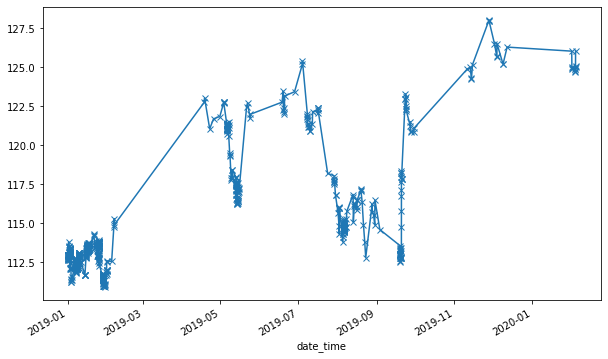

In [215]:
fig = plt.figure(figsize=(10,6))
axs = fig.add_subplot()
hist_vol_IB[0].set_index('date_time').close.plot(ax=axs,marker='x')
#hist_vol_IB[0].set_index('date_time').close.scatter(ax=axs)

In [138]:
hist_dol_IB = get_ema_dollar_imbalance_bars(hist_df.query('volume!=0'),num_prev_bars=10,expected_imbalance_window=100,exp_num_ticks_init=100)

Reading data in batches:
Batch number: 0
Returning bars 



In [139]:
hist_dol_IB[0]

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,2019-01-02 12:23:00+05:30,100,112.00,113.40,112.00,112.68,7763,4365,100,875359.00
1,2019-01-02 12:35:00+05:30,103,112.73,112.73,112.48,112.53,166,151,3,18689.43
2,2019-01-02 13:50:00+05:30,120,112.53,112.73,111.67,111.67,478,89,17,53579.47
3,2019-01-02 15:02:00+05:30,126,111.72,112.22,111.72,112.22,399,387,6,44728.08
4,2019-01-02 15:06:00+05:30,127,112.22,112.22,112.22,112.22,19,19,1,2132.18
...,...,...,...,...,...,...,...,...,...,...
321,2019-01-18 10:40:00+05:30,1015,112.57,113.80,112.52,113.66,6403,3936,218,724875.17
322,2019-01-18 13:06:00+05:30,1055,113.66,113.85,113.66,113.66,987,70,40,112183.94
323,2019-01-18 15:01:00+05:30,1077,113.66,114.00,113.66,113.66,722,4,22,82063.88
324,2019-01-18 15:19:00+05:30,1083,113.66,113.70,113.66,113.66,10547,1,6,1198772.06


In [222]:
hist_time = get_time_bars(hist_df,resolution='MIN',num_units=30)

Reading data in batches:
Batch number: 0
Returning bars 



In [225]:
hist_time['date_time'] = hist_time['date_time'].apply(lambda x: datetime.datetime.fromtimestamp(x))

In [235]:
hist_time.head(20)

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value,dollar_value
0,2019-01-01 09:30:00,16,113.35,113.35,112.62,112.72,145,1,15,16369.00,16369.00
1,2019-01-01 10:00:00,46,112.72,112.93,112.67,112.67,274,59,30,30879.18,14510.18
2,2019-01-01 10:30:00,76,112.64,112.78,112.61,112.78,3354,491,30,378021.19,347142.01
3,2019-01-01 11:00:00,106,112.78,112.91,112.67,112.75,254,236,30,28644.91,349376.28
4,2019-01-01 11:30:00,136,112.73,112.99,112.73,112.76,20205,12699,30,2282311.24,2253666.33
5,2019-01-01 12:00:00,166,112.76,112.90,112.74,112.76,168,10,30,18943.26,2263367.98
6,2019-01-01 12:30:00,196,112.76,112.94,112.75,112.92,303,142,30,34194.45,15251.19
7,2019-01-01 13:00:00,226,112.92,112.92,112.66,112.79,2152,19,30,242717.17,208522.72
8,2019-01-01 13:30:00,255,112.79,112.79,112.75,112.75,187,0,29,21084.25,221632.92
9,2019-01-01 14:00:00,285,112.75,112.87,112.63,112.63,603,1,30,67927.51,46843.26


In [231]:
hist_time['dollar_value'] = np.abs(hist_time['cum_dollar_value'].diff())
hist_time.loc[0,'dollar_value'] = hist_time['cum_dollar_value'].iloc[0]

In [232]:
exp_volume,std_volume = hist_time['volume'].mean(),hist_time['volume'].std()
exp_dollar,std_dollar = hist_time['dollar_value'].mean(),hist_time['dollar_value'].std()

In [234]:
exp_dollar,exp_volume

(2170451.4462048355, 12960.60880195599)

In [287]:
hist_volume = get_volume_bars(hist_df,threshold=15000)

Reading data in batches:
Batch number: 0
Returning bars 



In [291]:
hist_volume.shape

(1577, 11)

In [276]:
hist_dollar = get_dollar_bars(hist_df,threshold=exp_dollar//2)

Reading data in batches:
Batch number: 0
Returning bars 



In [288]:
hist_time['log_ret'] = np.log(hist_time['close']).diff()
hist_volume['log_ret'] = np.log(hist_volume['close']).diff()
hist_dollar['log_ret'] = np.log(hist_dollar['close']).diff()

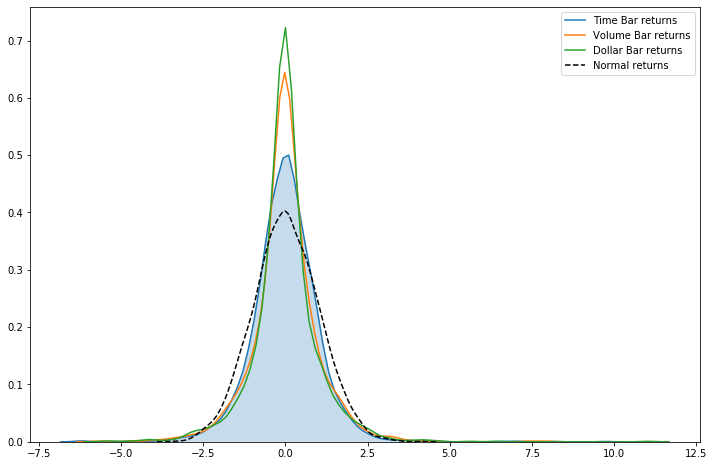

In [292]:
fig=plt.figure(figsize=(12,8))
axs = fig.add_subplot()
sns.kdeplot((hist_time['log_ret']-hist_time['log_ret'].mean())/hist_time['log_ret'].std(),shade=True,label = 'Time Bar returns',ax=axs)
sns.kdeplot((hist_volume['log_ret']-hist_volume['log_ret'].mean())/hist_volume['log_ret'].std(),shade=False,label = 'Volume Bar returns',ax=axs)
sns.kdeplot((hist_dollar['log_ret']-hist_dollar['log_ret'].mean())/hist_dollar['log_ret'].std(),shade=False,label = 'Dollar Bar returns',ax=axs)
sns.kdeplot(np.random.normal(size=len(hist_time)),label = 'Normal returns',color='black',linestyle='--')
#sns.kdeplot(np.log(hist_time['close']).diff(),shade=True,label='log-ret')
plt.show()

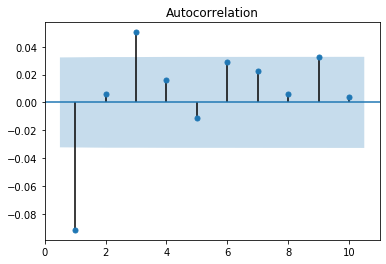

In [299]:
plot_acf(hist_time['log_ret'].fillna(0),lags=10, zero=False)
plt.show()


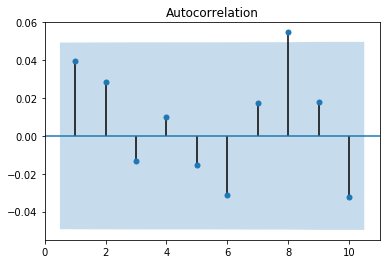

In [297]:
plot_acf(hist_volume['log_ret'].fillna(0),lags=10, zero=False)
plt.show()


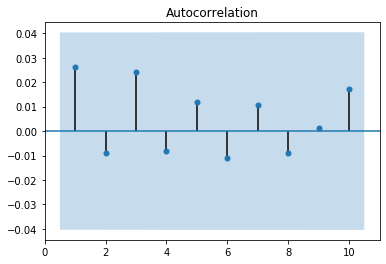

In [298]:
plot_acf(hist_dollar['log_ret'].fillna(0),lags=10, zero=False)
plt.show()


In [304]:
print('Test Statistics:')
print('Time:', '\t', int(stats.jarque_bera(hist_time['log_ret'].fillna(0))[0]))
print('Volume: ', int(stats.jarque_bera(hist_volume['log_ret'].fillna(0))[0]))
print('Dollar: ', int(stats.jarque_bera(hist_dollar['log_ret'].fillna(0))[0]))

Test Statistics:
Time: 	 9163
Volume:  2916
Dollar:  10820
